# Deploy a Flask ML application to AWS Elastic Beanstalk to predict Top-Rated Wine 

The Wine Quality Data Set along with additional information about can be found on the <a href='https://archive.ics.uci.edu/ml/datasets/wine+quality' target='_blank'>UCI Machine Learning Repository</a>


**Load red and white wine quality data sets**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
warnings.filterwarnings('ignore')

In [5]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Source:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
# if you cannot download the files try doing it manually
# if have an ssl error  Mac try fix: "/Applications/Python\ 3.6/Install\ Certificates.command"

red = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                  sep=";")
white = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
                    sep=";")

**Merge both data sets together**

In [8]:
# create a new wine color feature
white['color'] = 0
red['color'] = 1

# concat both data sets together
wine_df = pd.concat([white, red], ignore_index=True)


**Explore the Data**

In [9]:
# feature data types
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In [8]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


In [10]:
# what about our outcome column?
wine_df['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

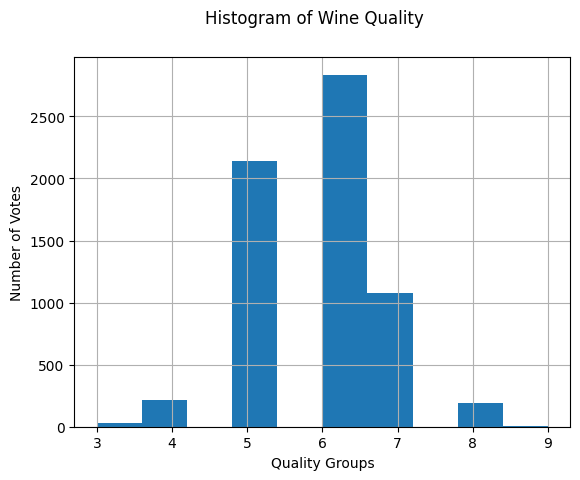

In [11]:
wine_df['quality'].hist()
plt.suptitle('Histogram of Wine Quality')
plt.xlabel('Quality Groups')
plt.ylabel('Number of Votes')
plt.show()

**What can we do to classify this data with such imbalannced edges?**

In [12]:

# try balancing the data somewhat by limiting each category to 500 samples
wine_quality_scale = set(wine_df['quality'])

temp_df = []
for quality in wine_quality_scale:
    wine_df_tmp = wine_df[wine_df['quality']==quality]
    # sample down any categories with ovrer 500 entries
    if (len(wine_df_tmp) > 500):
        wine_df_tmp = wine_df_tmp.sample(500, replace=False)
    temp_df.append(wine_df_tmp)    
len(temp_df)     

wine_balanced_df = pd.concat(temp_df)

print(wine_balanced_df['quality'].value_counts())

quality
5    500
6    500
7    500
4    216
8    193
3     30
9      5
Name: count, dtype: int64


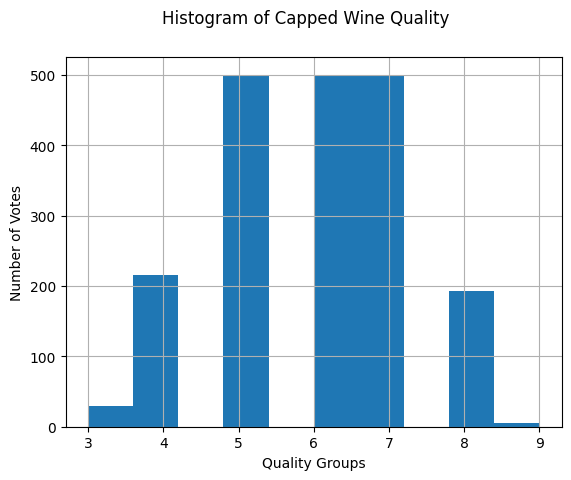

In [13]:
wine_balanced_df['quality'].hist()
plt.suptitle('Histogram of Capped Wine Quality')
plt.xlabel('Quality Groups')
plt.ylabel('Number of Votes')
plt.show()

**The edges still are imbalanced, so a better way would be re-balance the groupings:**

<TABLE>
<TR><TD>Old Quality</TD><TD>New Quality</TD></TR>
<TR><TD>3,4,5</TD><TD>3</TD></TR>
<TR><TD>6</TD><TD>6</TD></TR>
<TR><TD>7,8,9</TD><TD>9</TD></TR>
</TABLE>

In [14]:
# balance categories more equally
wine_df_bad = wine_df[wine_df['quality'].isin([3,4,5])]
wine_df_bad['quality'] = 3
wind_df_average = wine_df[wine_df['quality']==6]
wind_df_average['quality'] = 6
wind_df_good = wine_df[wine_df['quality'].isin([7,8,9])]
wind_df_good['quality'] = 9
wine_df = pd.concat([wine_df_bad,wind_df_average,wind_df_good], ignore_index=True)

# save a copy to file for our web application
wine_df.to_csv('wine_df.csv', index=False)

print(wine_df['quality'].value_counts())

quality
6    2836
3    2384
9    1277
Name: count, dtype: int64


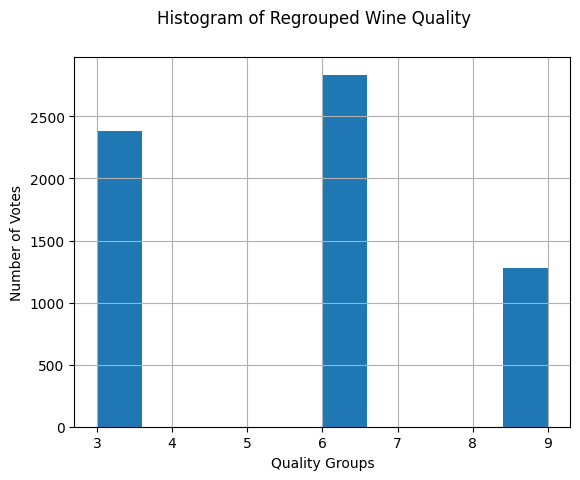

In [15]:

wine_df['quality'].hist()
plt.suptitle('Histogram of Regrouped Wine Quality')
plt.xlabel('Quality Groups')
plt.ylabel('Number of Votes')
plt.show()

In [16]:
# !pip install scipy

In [16]:
features = [ft for ft in list(wine_df) if ft not in ['quality']]


wine_df['quality'] = pd.Categorical(wine_df['quality'])
wine_df['quality_class'] = wine_df['quality'].cat.codes
outcome = 'quality_class'
outcome_buckets = len(set(wine_df['quality_class']))

print(set(wine_df['quality_class']))
X_train, X_test, y_train, y_test = train_test_split(wine_df[features],
                        wine_df[outcome], test_size=0.2, random_state=1)
print(("len(X_train): %i, len(X_test): %i, len(y_train): %i, len(y_test): %i") % (len(X_train),
                                                                               len(X_test),
                                                                               len(y_train),
                                                                               len(y_test)))

{0, 1, 2}
len(X_train): 5197, len(X_test): 1300, len(y_train): 5197, len(y_test): 1300


**Modeling Time**

In [19]:
# pip install scikit-learn

from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm

gbm_model = GradientBoostingClassifier(random_state=10, learning_rate=0.1, max_depth=10)
gbm_model.fit(X_train[features], y_train)

# save the model so we don't have to train it in the web application
with open('eb-flask/pickles/gbm_model_dump2.p', 'wb') as f:
     pickle.dump(gbm_model, f, 2)
                
gbm_model = pickle.load(open("eb-flask/pickles/gbm_model_dump2.p", "rb" ))

In [23]:
# Predicting Using the Testing Data Split
preds = gbm_model.predict_proba(X_test)
print(preds[0])
print('Argmax: %i' % np.argmax(preds[0]))
print('Quality class: %i' % list(wine_df['quality'].cat.categories)[np.argmax(preds[0])])

[0.18075537 0.78714577 0.03209886]
Argmax: 1
Quality class: 6


In [24]:
# get highest probability for each quality classes
from sklearn.metrics import precision_score
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Precision_score: %0.2f" % precision_score(y_test, best_preds, average='macro'))


Precision_score: 0.74


Confusion matrix, without normalization
[[346 112   6]
 [ 89 450  50]
 [  6  80 161]]


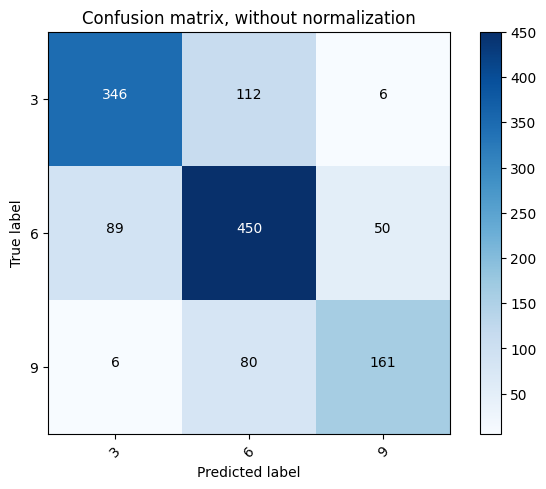

In [25]:
# confusion matrix
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, best_preds)

# Plot non-normalized confusion matrix
import matplotlib.pyplot as plt
plt.figure()
# use actual labels, not outcome code
plot_confusion_matrix(cnf_matrix, classes=list(wine_df['quality'].cat.categories),
                      title='Confusion matrix, without normalization')
 
plt.show()


<H2>Test predicting wine using new data</H2>

Get means, min, and max of all quantitative features to populate web application

In [26]:

fixed_acidity = np.mean(wine_df['fixed acidity']) # 7.215307
print('fixed_acidity: %f' % fixed_acidity)
print(('fixed_acidity min: %f, max: %f') % (np.min(wine_df['fixed acidity']), np.max(wine_df['fixed acidity'])))
print('--')

volatile_acidity = np.mean(wine_df['volatile acidity'])
print('volatile_acidity: %f' % volatile_acidity)
print(('volatile_acidity min: %f, max: %f') % (np.min(wine_df['volatile acidity']), np.max(wine_df['volatile acidity'])))
print('--')

citric_acid = np.mean(wine_df['citric acid'])
print('citric_acid: %f' % citric_acid)
print(('citric_acid min: %f, max: %f') % (np.min(wine_df['citric acid']), np.max(wine_df['citric acid'])))
print('--')

residual_sugar = np.mean(wine_df['residual sugar'])
print('residual_sugar: %f' % residual_sugar)
print(('residual_sugar min: %f, max: %f') % (np.min(wine_df['residual sugar']), np.max(wine_df['residual sugar'])))
print('--')

chlorides = np.mean(wine_df['chlorides'])
print('chlorides: %f' % chlorides)
print(('chlorides min: %f, max: %f') % (np.min(wine_df['chlorides']), np.max(wine_df['chlorides'])))
print('--')

free_sulfur_dioxide = np.mean(wine_df['free sulfur dioxide'])
print('free sulfur dioxide: %f' % free_sulfur_dioxide)
print(('free sulfur dioxide: %f, max: %f') % (np.min(wine_df['free sulfur dioxide']), np.max(wine_df['free sulfur dioxide'])))
print('--')

total_sulfur_dioxide = np.mean(wine_df['total sulfur dioxide'])
print('total_sulfur_dioxide: %f' % total_sulfur_dioxide)
print(('total sulfur dioxide: %f, max: %f') % (np.min(wine_df['total sulfur dioxide']), np.max(wine_df['total sulfur dioxide'])))
print('--')

density = np.mean(wine_df['density'])
print('density: %f' % density)
print(('density: %f, max: %f') % (np.min(wine_df['density']), np.max(wine_df['density'])))
print('--')

pH = np.mean(wine_df['pH'])
print('pH: %f' % pH)
print(('pH: %f, max: %f') % (np.min(wine_df['pH']), np.max(wine_df['pH'])))
print('--')

sulphates = np.mean(wine_df['sulphates'])
print('sulphates: %f' % sulphates)
print(('sulphates: %f, max: %f') % (np.min(wine_df['sulphates']), np.max(wine_df['sulphates'])))
print('--')

alcohol = np.mean(wine_df['alcohol'])
print('alcohol: %f' % alcohol)
print(('alcohol: %f, max: %f') % (np.min(wine_df['alcohol']), np.max(wine_df['alcohol'])))
print('--')

color = np.mean(wine_df['color'])
print('color: %i' % round(color))
print(('color: %f, max: %f') % (np.min(wine_df['color']), np.max(wine_df['color'])))
print('--')

color = 0

fixed_acidity: 7.215307
fixed_acidity min: 3.800000, max: 15.900000
--
volatile_acidity: 0.339666
volatile_acidity min: 0.080000, max: 1.580000
--
citric_acid: 0.318633
citric_acid min: 0.000000, max: 1.660000
--
residual_sugar: 5.443235
residual_sugar min: 0.600000, max: 65.800000
--
chlorides: 0.056034
chlorides min: 0.009000, max: 0.611000
--
free sulfur dioxide: 30.525319
free sulfur dioxide: 1.000000, max: 289.000000
--
total_sulfur_dioxide: 115.744574
total sulfur dioxide: 6.000000, max: 440.000000
--
density: 0.994697
density: 0.987110, max: 1.038980
--
pH: 3.218501
pH: 2.720000, max: 4.010000
--
sulphates: 0.531268
sulphates: 0.220000, max: 2.000000
--
alcohol: 10.491801
alcohol: 8.000000, max: 14.900000
--
color: 0
color: 0.000000, max: 1.000000
--


In [34]:
# test predicting wine entry from new data
# default wine constants based on data mean values
 
# create data set of new data
x_test_tmp = pd.DataFrame([[fixed_acidity,
                             volatile_acidity,
                             citric_acid,
                             residual_sugar,
                             chlorides,
                             free_sulfur_dioxide,
                             total_sulfur_dioxide,
                             density,
                             pH,
                             sulphates,
                             alcohol,
                             color]], columns = X_test.columns.values)

# predict quality based on incoming values
preds = gbm_model.predict_proba((x_test_tmp))
print(preds)
# get best quality prediction from original quality scale
print(('Predicted wine quality: %i') % list(wine_df['quality'].cat.categories)[np.argmax(preds)])
# get mean quality to compare
print(('Actual mean wine quality: %0.2f') % np.mean(wine_df['quality'].values))

[[0.48519258 0.49036672 0.0244407 ]]
Predicted wine quality: 6
Actual mean wine quality: 5.49
